# Figure 1: SLF curves for base and fitted models

### Add paths to run locally or off NIRD

In [1]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png
    )

from classes import SatComp_Metric, CT_SLF_Metric
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Check running location and adjust working directory appropriately.

In [2]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

output_dir = 'figures/'
case_dir = 'satcomp/'   # inconsistent label compared to jupy_test
conv_dir ='convectivephase/'

# Check that each important directory can be accessed:    
access_paths = os.path.exists(output_dir) and os.path.exists(case_dir) and os.path.exists(conv_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


## Load data into metric classes

In [3]:
otherruns_metric = CT_SLF_Metric(case_dir)

otherruns_metric.add_case('20211124_102800_cam6satcomp16_wbf_1.25_inp_1', label="CAM6-Oslo WBF1.25 INP1")
otherruns_metric.add_case('20211124_102800_cam6satcomp16_wbf_1_inp_10', label="CAM6-Oslo WBF1 INP10")
otherruns_metric.add_case('20211124_103400_cam6satcomp16_wbf_0.5_inp_1', label="CAM6-OsloIce WBF0.5 INP1")
otherruns_metric.add_case('20211124_103600_cam6satcomp16_wbf_1_inp_0.05', label="CAM6-OsloIce WBF1 INP0.05")
otherruns_metric.add_case('20211124_103800_cam6satcomp16_wbf_0.2_inp_1', label="CAM6-OsloIce WBF0.2 INP1")
otherruns_metric.add_case('20211124_103900_cam6satcomp16_wbf_1_inp_0.1', label="CAM6-OsloIce WBF1 INP0.1")
# otherruns_metric.add_case('20200414_205148_singleparam_cam61satcomp_wbf_1_inp_1', label="CAM6-OsloIce")
# otherruns_metric.add_case('20211120_cam62satcomp_wbf_1_inp_1', label="CAM6-OsloIce-NoSecondary")

Trying to load concatenated file for 20211124_102800_cam6satcomp16_wbf_1.25_inp_1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20211124_102800_cam6satcomp16_wbf_1_inp_10


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20211124_103400_cam6satcomp16_wbf_0.5_inp_1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20211124_103600_cam6satcomp16_wbf_1_inp_0.05


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20211124_103800_cam6satcomp16_wbf_0.2_inp_1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20211124_103900_cam6satcomp16_wbf_1_inp_0.1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [19]:
save_dict = {}

for _casename in otherruns_metric.get_cases():
    case_da = otherruns_metric.get_case(_casename).case_da
    slf_avg = masked_average(case_da['CT_SLF_TAVG'].sel(lat=slice(66,None)),weights=case_da['cell_weight'],dim=['lat','lon'])
    
    save_dict[_casename] = slf_avg.values
    
save_dict

{'20211124_102800_cam6satcomp16_wbf_1.25_inp_1': array([0.04552452, 0.27212925, 0.47064839, 0.71164886, 0.87986859,
        0.95033369, 0.98145678, 0.9976638 , 0.99963227]),
 '20211124_102800_cam6satcomp16_wbf_1_inp_10': array([0.05385359, 0.2770469 , 0.48097249, 0.73169693, 0.88559639,
        0.95361536, 0.98197899, 0.99753196, 0.99965311]),
 '20211124_103400_cam6satcomp16_wbf_0.5_inp_1': array([0.04258131, 0.05242366, 0.11888936, 0.28951538, 0.76257104,
        0.92401048, 0.96827091, 0.99490383, 0.99955984]),
 '20211124_103600_cam6satcomp16_wbf_1_inp_0.05': array([0.03907804, 0.13873691, 0.28909389, 0.6134991 , 0.88860282,
        0.94821221, 0.97991058, 0.99437899, 0.999499  ]),
 '20211124_103800_cam6satcomp16_wbf_0.2_inp_1': array([0.05226839, 0.07943322, 0.14576411, 0.31009852, 0.68223901,
        0.8917869 , 0.9630417 , 0.99320923, 0.9991769 ]),
 '20211124_103900_cam6satcomp16_wbf_1_inp_0.1': array([0.03571902, 0.10205153, 0.22410199, 0.52871673, 0.87805602,
        0.94748023,

#### Visualize too how these runs perform w.r.t. SLF

In [4]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True

Unsuccessful attempt to use siunitx to do units :(

In [5]:
pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots 
    "font.sans-serif": [],              # to inherit fonts from the document
    "font.monospace": [],
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts 
    "xtick.labelsize": 8,               # a little smaller
    "ytick.labelsize": 8,
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts 
        r"\usepackage[T1]{fontenc}",        # plots will be generated
        r"\usepackage[detect-all,locale=DE]{siunitx}",
        ]                                   # using this preamble
    }
# }}}
mpl.rcParams.update(pgf_with_latex)

#     "figure.figsize": figsize(0.9),     # default fig size of 0.9 textwidth

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5,0.05,'SLF (%)')

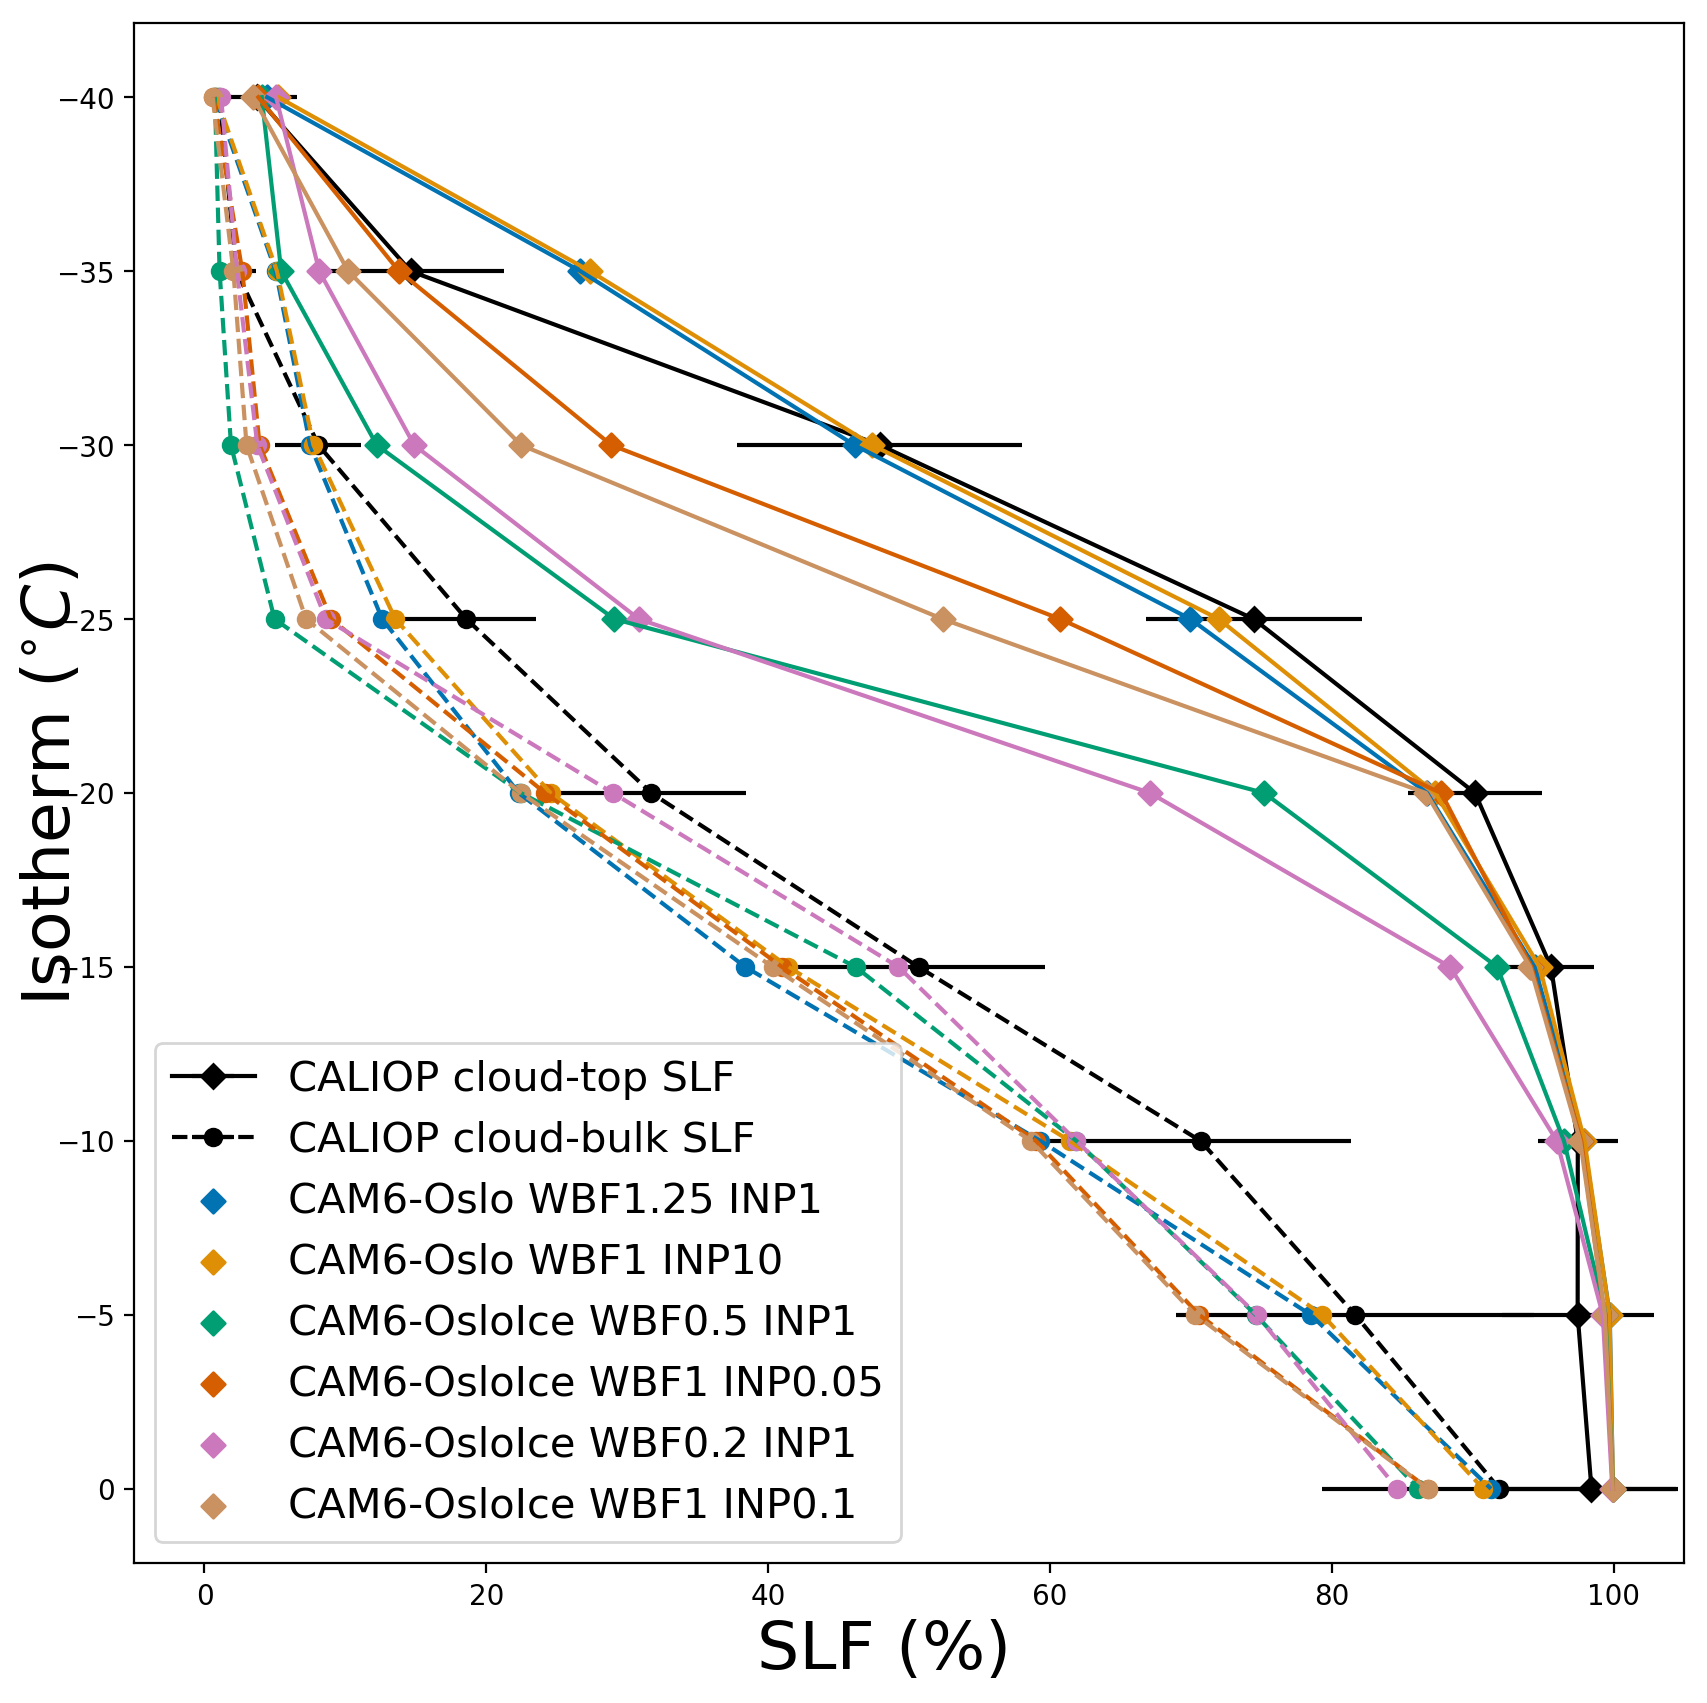

In [7]:
# Use different colors for the two subplots. Use the Seaborn colorblind palette (really pretty!)
plt.style.use('default')
otherruns_metric.colors = sns.color_palette("colorblind")#[:3] 

fig,ax = plt.subplots(nrows=1,ncols=1)#,sharey=True)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.set_dpi(200)

# axs[0].invert_yaxis()
o = otherruns_metric.plot_isos_all(ax=ax)

fig.subplots_adjust(wspace=0.0)

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')
# axs[1].set_yticks(np.arange(-40,0,5),' ')
# axs[1].get_yaxis().set_ticks([])
# axs[1].set_yticklabels([])
# axs[0].set_xticklabels(axs[0].get_xticklabels(), fontsize=15)
# axs[1].set_xticklabels(axs[1].get_xticklabels(), fontsize=15)
# axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=15)
# axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=15)
# handles, labels = axs[1].get_legend_handles_labels()
# axs[1].legend(handles, labels, loc = 'lower left')

fig.text(0.07, 0.5, r'Isotherm ($^{\circ}C$)', va='bottom', ha='center', rotation='vertical', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.5, 0.05, 'SLF (%)', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)

# fig.text(0.15, 0.2, 'a.', va='bottom', ha='center', rotation='horizontal', 
#          rotation_mode='anchor', fontsize=24)
# fig.text(0.55, 0.2, 'b.', va='bottom', ha='center', rotation='horizontal', 
#          rotation_mode='anchor', fontsize=24)

# fig.text(0.45, 0.8, 'a.', va='bottom', ha='center', rotation='horizontal', 
#          rotation_mode='anchor', fontsize=24)
# fig.text(0.85, 0.8, 'b.', va='bottom', ha='center', rotation='horizontal', 
#          rotation_mode='anchor', fontsize=24)

#### Compare the raw values to be certain

In [16]:
osloice_case = secice_slf.cases['20200414_205148_singleparam_cam61satcomp_wbf_1_inp_1']
olsoice_nosec = secice_slf.cases['20211120_cam62satcomp_wbf_1_inp_1']

In [17]:
osloice_slf = osloice_case.case_da['SLF_ISOTM'].sel(lat=slice(66,None)).mean(dim=['lat','lon'])
osloice_nosec_slf = olsoice_nosec.case_da['SLF_ISOTM'].sel(lat=slice(66,None)).mean(dim=['lat','lon'])

In [18]:
print(osloice_slf.values)
print(osloice_nosec_slf.values)

[0.00565786 0.00651039 0.01032269 0.02514878 0.13906223 0.37979686
 0.5848681  0.7367727  0.8994282 ]
[0.00570924 0.00660788 0.01024162 0.02498003 0.13887036 0.38075212
 0.587109   0.73675585 0.8991634 ]


In [19]:
osloice_ctslf = osloice_case.case_da['CT_SLF_ISOTM_AVG'].sel(lat=slice(66,None)).mean(dim=['lat','lon'])
osloice_nosec_ctslf = olsoice_nosec.case_da['CT_SLF_ISOTM_AVG'].sel(lat=slice(66,None)).mean(dim=['lat','lon'])

In [20]:
print(osloice_ctslf.values)
print(osloice_nosec_ctslf.values)

[0.02992361 0.02188606 0.05477092 0.19335744 0.75904095 0.94322896
 0.97971666 0.9960898  0.99967766]
[0.03045932 0.02022585 0.05363526 0.19668448 0.7607534  0.94480467
 0.97884923 0.99586165 0.99967074]
